# Evaluation of Graph Neural Network segment classifier

In [1]:
%pwd

'/global/u2/d/danieltm/ExaTrkX/heptrkx-gnn-tracking/notebooks'

In [1]:
# System imports
import os
import sys
from pprint import pprint as pp


# External imports
import matplotlib.pyplot as plt
import numpy as np

# Limit CPU usage on Jupyter
os.environ['OMP_NUM_THREADS'] = '4'

# Pick up local packages
sys.path.append('..')

# Local imports
from trainers import get_trainer
from nb_utils import (load_config_file, load_config_dir, load_summaries,
                      plot_train_history, get_test_data_loader,
                      compute_metrics, plot_metrics, draw_sample_xy, draw_triplets_xy, get_dataset)

In [2]:
%matplotlib inline

## Load training results

Specify which results to load either by config file or training output directory.

In [3]:
# Load by config file
config_file = '../configs/tripgnn_med.yaml'
config = load_config_file(config_file)
summaries = load_summaries(config)

In [4]:
# Load by directory (preferred)
result_base = os.path.expandvars('/global/cscratch1/sd/danieltm/ExaTrkX/triplet_results/checkpoints_med')

In [5]:
result_name = 'agnn02'
result_dir = os.path.join(result_base, result_name)

config = load_config_dir(result_dir)
print('Configuration:')
pp(config)

summaries = load_summaries(config)
print('\nTraining summaries:')
summaries

Configuration:
{'data': {'batch_size': 4,
          'input_dir': '/global/cscratch1/sd/danieltm/ExaTrkX/triplet_data/hitgraphs_med',
          'n_train': 1920,
          'n_valid': 80,
          'n_workers': 4,
          'name': 'hitgraphs_sparse',
          'real_weight': 3.0},
 'model': {'hidden_dim': 64,
           'input_dim': 7,
           'layer_norm': True,
           'loss_func': 'binary_cross_entropy_with_logits',
           'n_graph_iters': 3,
           'name': 'tripgnn'},
 'n_ranks': 1,
 'optimizer': {'learning_rate': 0.01,
               'lr_decay_schedule': [{'end_epoch': 25,
                                      'factor': 0.5,
                                      'start_epoch': 10},
                                     {'end_epoch': 40,
                                      'factor': 0.01,
                                      'start_epoch': 25},
                                     {'end_epoch': 50,
                                      'factor': 0.005,
               

,lr,train_loss,l1,l2,epoch,train_time,valid_loss,valid_acc,valid_time
0,0.01000,0.543906,5555.554894,170.790769,0,66.577327,0.937875,0.714012,1.714154
1,0.01000,0.399588,5802.526887,186.532917,1,65.983641,0.172344,0.936334,1.593416
2,0.01000,0.150020,5822.716031,189.231290,2,65.765237,0.136028,0.944074,1.593735
3,0.01000,0.138693,5835.690972,190.958241,3,65.665213,0.284043,0.849298,1.593498
4,0.01000,0.134838,5850.550570,192.258600,4,65.713242,0.137543,0.940164,1.593192
5,0.01000,0.131710,5865.281427,193.689751,5,65.844559,0.146407,0.935202,1.594826
6,0.01000,0.130530,5888.391839,195.398216,6,65.901236,0.138119,0.938328,1.594850
7,0.01000,0.131571,5988.565839,200.017307,7,65.882637,0.141035,0.936374,1.599366
8,0.01000,0.128126,6009.895947,202.061343,8,65.842451,0.130512,0.943401,1.603883
9,0.01000,0.122678,6078.443481,206.882044,9,65.649131,0.126367,0.944400,1.591316


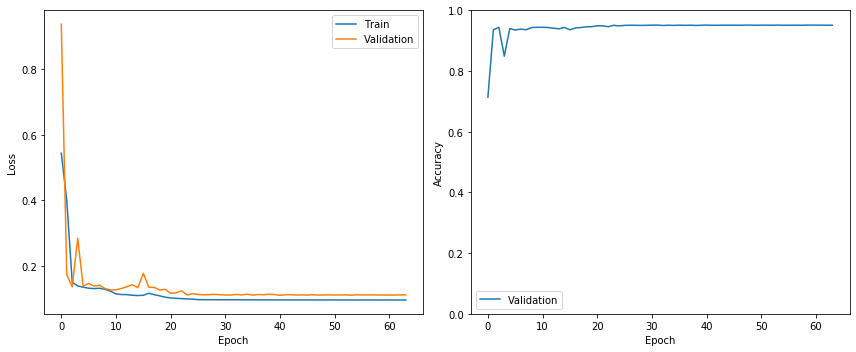

In [6]:
plot_train_history(summaries)

Text(0, 0.5, 'Learning rate')

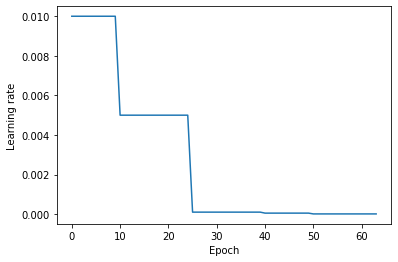

In [7]:
# Plot the learning rate
plt.figure()
plt.plot(summaries.lr)
plt.xlabel('Epoch')
plt.ylabel('Learning rate')

## Load the trained model

In [8]:
# Find the best epoch
best_idx = summaries.valid_loss.idxmin()
summaries.loc[[best_idx]]

,lr,train_loss,l1,l2,epoch,train_time,valid_loss,valid_acc,valid_time
40,0.00005,0.09598,9034.433166,271.623412,40,65.859984,0.110001,0.951619,1.612672


In [9]:
# Build the trainer and load best checkpoint
trainer = get_trainer(output_dir=config['output_dir'], **config['trainer'])
trainer.build_model(optimizer_config=config['optimizer'], **config['model'])

best_epoch = summaries.epoch.loc[best_idx]
trainer.load_checkpoint(checkpoint_id=best_epoch)

print(trainer.model)
print('Parameters:', sum(p.numel() for p in trainer.model.parameters()))

GNNSegmentClassifier(
  (input_network): Sequential(
    (0): Linear(in_features=7, out_features=64, bias=True)
    (1): LayerNorm(torch.Size([64]), eps=1e-05, elementwise_affine=True)
    (2): Tanh()
  )
  (edge_network): EdgeNetwork(
    (network): Sequential(
      (0): Linear(in_features=142, out_features=64, bias=True)
      (1): LayerNorm(torch.Size([64]), eps=1e-05, elementwise_affine=True)
      (2): Tanh()
      (3): Linear(in_features=64, out_features=64, bias=True)
      (4): LayerNorm(torch.Size([64]), eps=1e-05, elementwise_affine=True)
      (5): Tanh()
      (6): Linear(in_features=64, out_features=64, bias=True)
      (7): LayerNorm(torch.Size([64]), eps=1e-05, elementwise_affine=True)
      (8): Tanh()
      (9): Linear(in_features=64, out_features=1, bias=True)
    )
  )
  (node_network): NodeNetwork(
    (network): Sequential(
      (0): Linear(in_features=213, out_features=64, bias=True)
      (1): LayerNorm(torch.Size([64]), eps=1e-05, elementwise_affine=True)
    

## Evaluate the model on the test dataset

In [10]:
# Load the test dataset
n_test = 64
test_loader = get_test_data_loader(config, n_test=n_test)

In [11]:
%%time
# Apply the model
test_preds, test_targets = trainer.predict(test_loader)

CPU times: user 8min 13s, sys: 13.1 s, total: 8min 26s
Wall time: 2min 10s


In [12]:
threshold = 0.5
test_metrics = compute_metrics(test_preds, test_targets, threshold=threshold)

print('Test set results with threshold of', threshold)
print('Accuracy:  %.4f' % test_metrics.accuracy)
print('Precision: %.4f' % test_metrics.precision)
print('Recall:    %.4f' % test_metrics.recall)

Test set results with threshold of 0.5
Accuracy:  0.9521
Precision: 0.9402
Recall:    0.9961


In [13]:
threshold = 0.8
test_metrics = compute_metrics(test_preds, test_targets, threshold=threshold)

print('Test set results with threshold of', threshold)
print('Accuracy:  %.4f' % test_metrics.accuracy)
print('Precision: %.4f' % test_metrics.precision)
print('Recall:    %.4f' % test_metrics.recall)

Test set results with threshold of 0.8
Accuracy:  0.9620
Precision: 0.9646
Recall:    0.9828


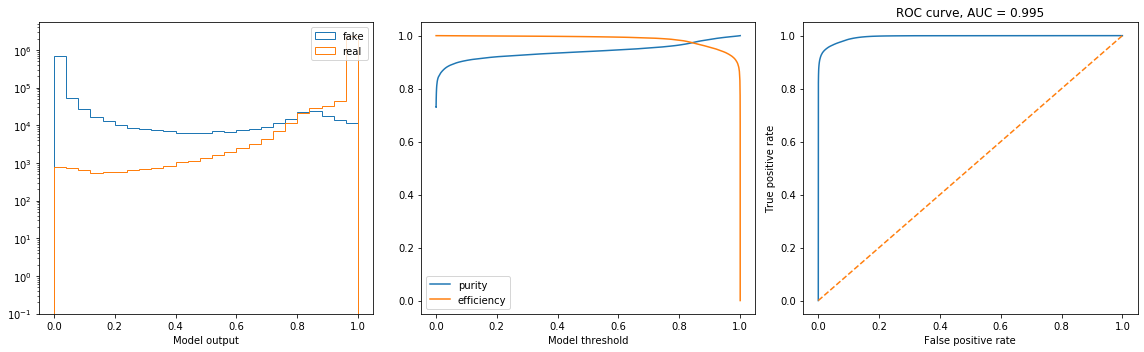

In [14]:
plot_metrics(test_preds, test_targets, test_metrics)

## Visualize predictions

In [15]:
n_phi_sections = 4
feature_scale = np.array([1000., np.pi / n_phi_sections, 1000., 1000., np.pi / n_phi_sections, 1000., 1])

In [35]:
i = 1

g = test_loader.dataset[i]
e = g.edge_index.numpy()
x = g.x.numpy() * feature_scale
y = g.y.numpy()
o = test_preds[i].numpy()

In [36]:
len(y)

27518

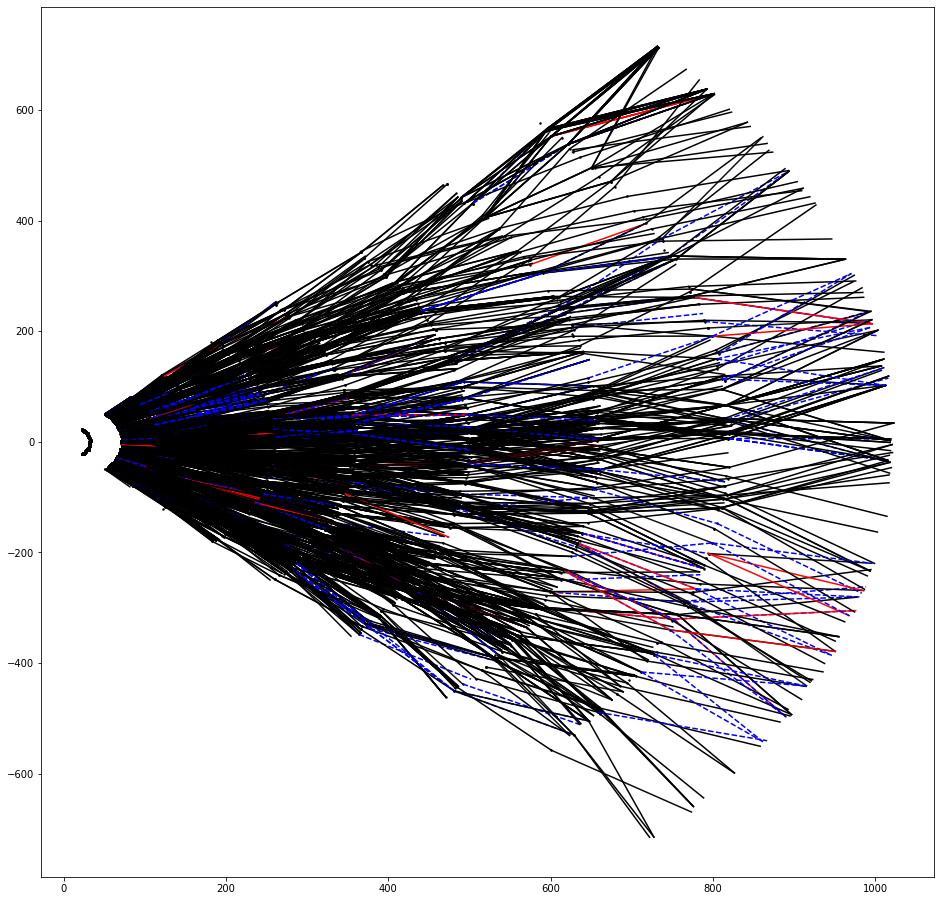

In [38]:
draw_triplets2_xy(x, e, o, y, cut=0.9);

In [37]:
def draw_triplets2_xy(hits, edges, preds, labels, cut=0.5, figsize=(16, 16)):
    xi, yi = [hits[:,0] * np.cos(hits[:,1]), hits[:,0] * np.sin(hits[:,1])]
    xo, yo = [hits[:,3] * np.cos(hits[:,4]), hits[:,3] * np.sin(hits[:,4])]
    fig, ax0 = plt.subplots(figsize=figsize)

#     Draw the hits
    ax0.scatter(xi, yi, s=2, c='k')

    # Draw the segments
    for j in range(labels.shape[0]):

        # False negatives
        if preds[j] < cut and labels[j] > cut:
            ax0.plot([xi[edges[0,j]], xo[edges[0,j]]],
                     [yi[edges[0,j]], yo[edges[0,j]]],
                     '--', c='b')

        # False positives
        if preds[j] > cut and labels[j] < cut:
            ax0.plot([xi[edges[0,j]], xo[edges[0,j]]],
                     [yi[edges[0,j]], yo[edges[0,j]]],
                     '-', c='r', alpha=preds[j])

        # True positives
        if preds[j] > cut and labels[j] > cut:
            ax0.plot([xi[edges[0,j]], xo[edges[0,j]]],
                     [yi[edges[0,j]], yo[edges[0,j]]],
                     '-', c='k', alpha=preds[j])

    return fig, ax0

## Writing data files

In [97]:
n_test = 10
test_loader = get_test_data_loader(config, n_test=n_test)
test_preds, test_targets = trainer.predict(test_loader)

In [30]:
len(test_preds)

10

In [37]:
len(test_preds[1])

4263

In [44]:
g = test_loader.dataset[0]
e = g.edge_index.numpy()
x = g.x.numpy() * feature_scale
y = g.y.numpy()
o = test_preds[i].numpy()

In [46]:
len(o)

53970

In [53]:
e[:,0]

array([5512,  347])

In [66]:
x[e[0,1000]],x[e[1,1000]]

(array([ 7.16653913e+01,  7.68787138e-01, -2.99602002e+01,  1.15002297e+02,
         7.83129915e-01, -1.07385002e+02,  6.83567996e-05]),
 array([ 3.19514759e+01,  7.61692056e-01, -2.77606994e+01,  7.16653913e+01,
         7.68787138e-01, -2.99602002e+01,  3.50703089e-03]))

In [58]:
y[0]

1.0

In [60]:
o[0]

0.99949276

## Resolve Multiplicities